In [7]:
import os
import urllib
import sys

import cv2
import numpy as np
import matplotlib.pyplot as plt

import skimage.io as io
from skimage.util import random_noise

from sklearn.model_selection import train_test_split

from torch.optim import lr_scheduler

import glob

In [8]:
train_list = glob.glob('../dataset/BSD300/images/train/*')
test_list = glob.glob('../dataset/BUSI/malignant/*).png')

In [28]:
ims = []

for image in train_list:
  im =  io.imread(image, as_gray = True)
  image = cv2.resize(im, (256, 256))
  
  img90 = cv2.rotate(image, cv2.ROTATE_90_CLOCKWISE) # 시계방향으로 90도 회전
  img180 = cv2.rotate(image, cv2.ROTATE_180) # 180도 회전
  img270 = cv2.rotate(image, cv2.ROTATE_90_COUNTERCLOCKWISE) # 반시계방향으로 90도 회전
  
  
  ims.extend([image, img90, img180, img270])

ims = np.array(ims)

In [29]:
noised_dataset = []
for img in ims:
  noisy = random_noise(img, mode = 'speckle', var=0.003)
  noised_dataset.append(noisy)

noised_dataset = np.array(noised_dataset)
noised_dataset.shape

(800, 256, 256)

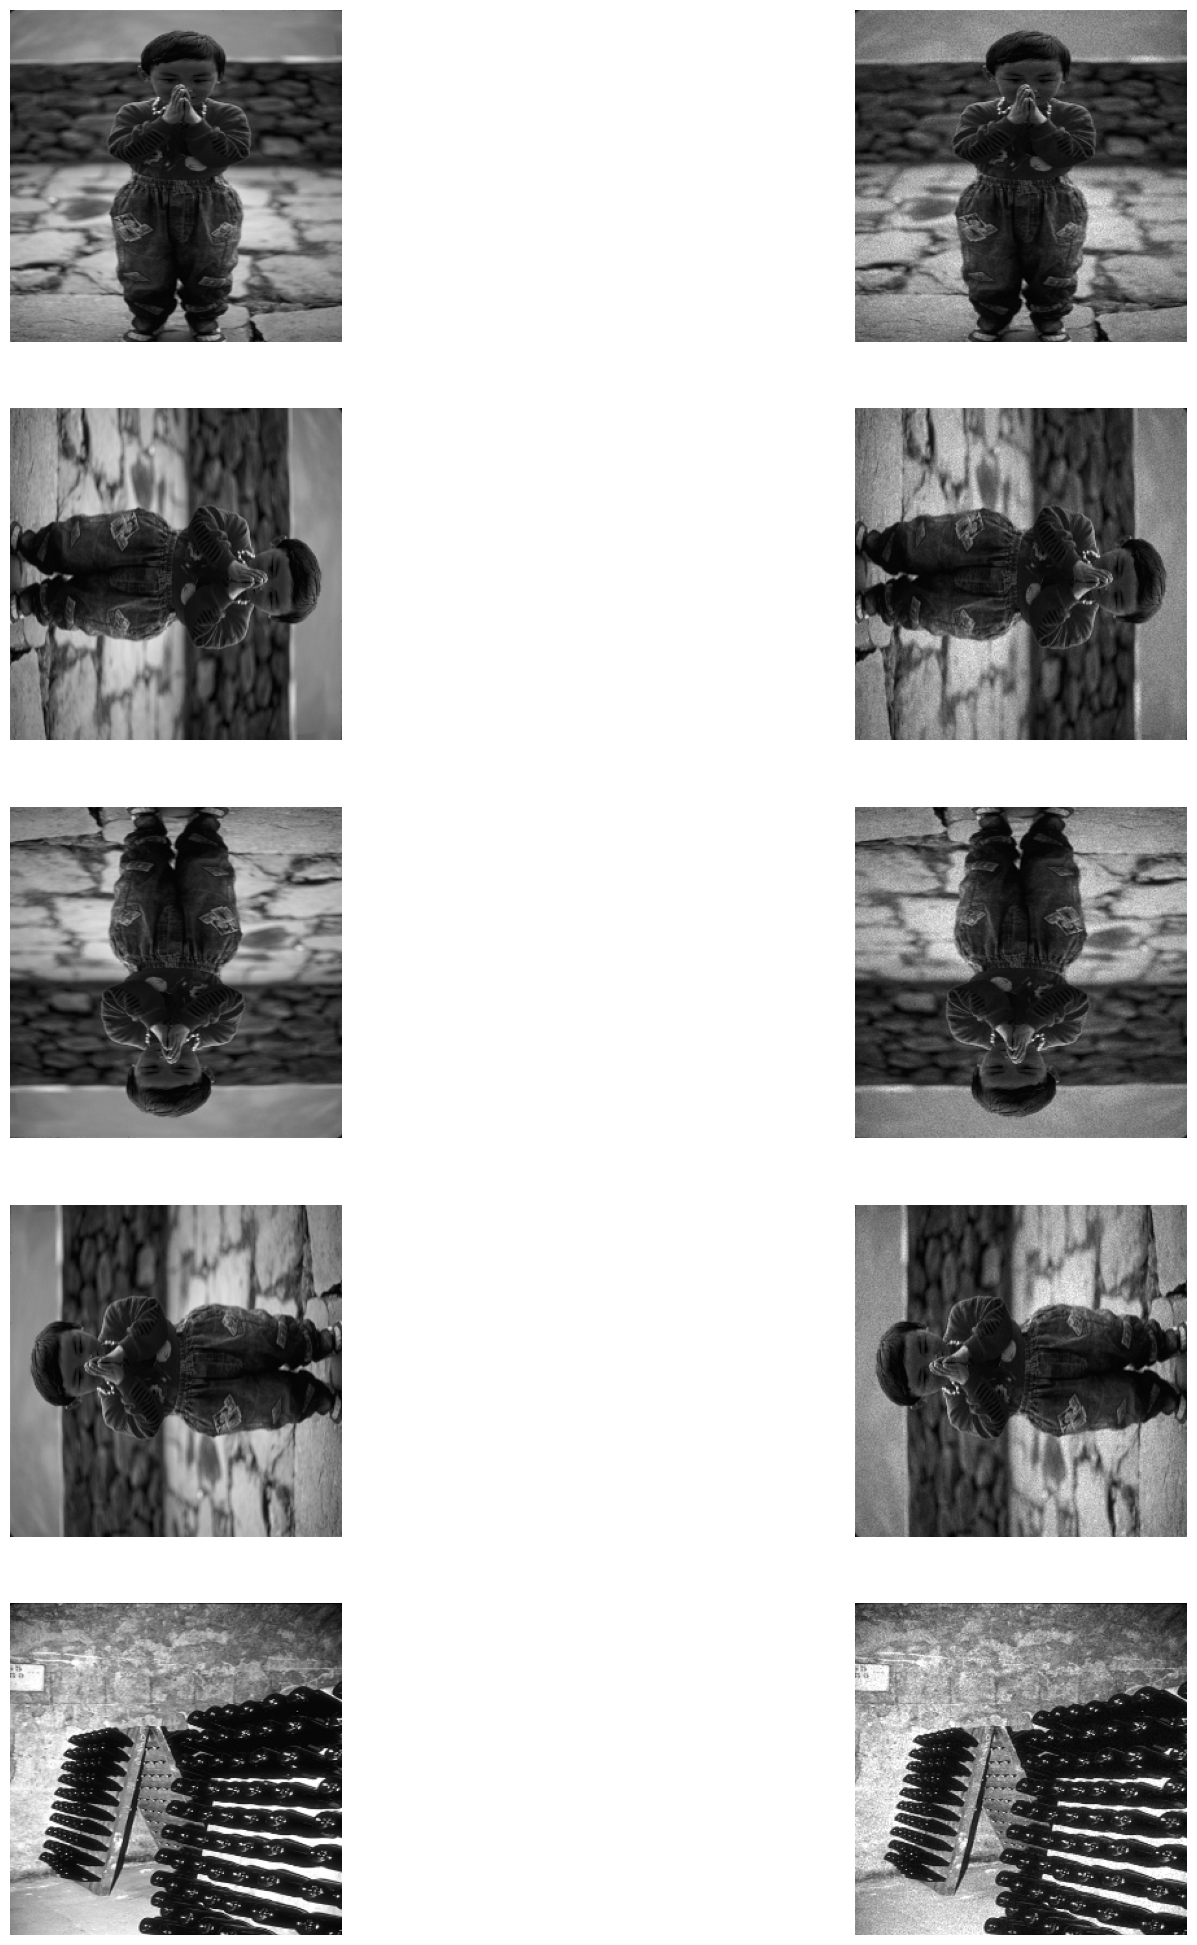

In [30]:
N_show = 5

plt.figure(figsize=(10*2, 5*N_show))
for i in range(N_show):
  plt.subplot(N_show, 2, 2*i+1)
  plt.imshow(ims[i], cmap='gray')
  plt.axis('off')

  plt.subplot(N_show, 2, 2*i+2)
  plt.imshow(noised_dataset[i], cmap='gray')
  plt.axis('off')
plt.show()

In [2]:
import torch
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
import torchvision.models as models

class DnCNN(nn.Module):
    ### __init__ : 모델의 구조, 동작 정의. 객체 생성시 자동 호출(속성값 초기화) 
    def __init__(self, channels, num_of_layers=17): 
        super(DnCNN, self).__init__() # 부모 클래스 __init__ -> 자식 클래스로 가져옴
        kernel_size = 3
        padding = 1
        features = 64
        layers = []
        layers.append(nn.Conv2d(in_channels=channels, out_channels=features, kernel_size = kernel_size, padding=padding, bias=False))
        layers.append(nn.ReLU(inplace=True))
        for _ in range(num_of_layers-2):
          layers.append(nn.Conv2d(in_channels=features, out_channels=features, kernel_size=kernel_size, padding=padding, bias=False))
          layers.append(nn.BatchNorm2d(features))
          layers.append(nn.ReLU(inplace=True))
        layers.append(nn.Conv2d(in_channels=features, out_channels=channels, kernel_size=kernel_size, padding=padding, bias=False))
        self.dncnn = nn.Sequential(*layers) # self -> 인스턴스 가리킴 / 모든 계층 목록 nn.Sequential 클래스로 전달

    ### forward : 모델(입력 데이터)
    def forward(self, x):
      out = self.dncnn(x)
      return out

In [23]:
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"  # Arrange GPU devices starting from 0
os.environ["CUDA_VISIBLE_DEVICES"]= "0,1,2,3"  # Set the GPUs 2 and 3 to use


# GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# CPU
# device = "cpu"

print('Device:', device)
print('Current cuda device:', torch.cuda.current_device())
print('Count of using GPUs:', torch.cuda.device_count())

Device: cuda
Current cuda device: 0
Count of using GPUs: 4


In [9]:
model = DnCNN(channels = 1).to(device)

In [25]:
# Parallel

_model = DnCNN(channels = 1).cuda()
model = nn.DataParallel(_net).to(device)

In [26]:
model

DataParallel(
  (module): DnCNN(
    (dncnn): Sequential(
      (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (4): ReLU(inplace=True)
      (5): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (6): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (7): ReLU(inplace=True)
      (8): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (9): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (10): ReLU(inplace=True)
      (11): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (12): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (13):

In [31]:
ims.shape, noised_dataset.shape

((800, 256, 256), (800, 256, 256))

In [32]:
ims = ims[:, :, :, np.newaxis]
noised_dataset = noised_dataset[:, :, :, np.newaxis]

In [33]:
ims.shape, noised_dataset.shape

((800, 256, 256, 1), (800, 256, 256, 1))

In [34]:
N_ims , h, w, color = ims.shape
ims = ims[:N_ims].astype(np.float32).transpose(0, 3, 1, 2)
noised_dataset = noised_dataset[:N_ims].astype(np.float32).transpose(0, 3, 1, 2)

In [35]:
ims.shape, noised_dataset.shape

((800, 1, 256, 256), (800, 1, 256, 256))

In [36]:
# training hyperparameters
batch_size = 8
lr = 1e-3
epochs = 50
test_size = 0.05

In [37]:
# train test split

train_X, train_Y = noised_dataset, ims
print(train_X.shape)

train_X, test_X, train_Y, test_Y = train_test_split(train_X, train_Y, test_size=test_size, random_state=42)

print('Training X: ', train_X.shape, train_X.dtype, train_X.max(), train_X.min())
print('Training Y: ', train_Y.shape, train_Y.dtype, train_Y.max(), train_Y.min())
print('Testing X: ', test_X.shape, test_X.dtype, test_X.max(), test_X.min())
print('Testing Y: ', test_Y.shape, test_Y.dtype, test_Y.max(), test_Y.min())


(800, 1, 256, 256)
Training X:  (760, 1, 256, 256) float32 1.0 0.0005106658
Training Y:  (760, 1, 256, 256) float32 1.0 0.00053568085
Testing X:  (40, 1, 256, 256) float32 1.0 0.005105399
Testing Y:  (40, 1, 256, 256) float32 1.0 0.0050675506


In [38]:
class MyDataset(torch.utils.data.Dataset):
    
      def __init__(self, X, Y):
          self.X = X
          self.Y = Y

      def __getitem__(self, index):
          return self.X[index], self.Y[index]

      def __len__(self):  
          return len(self.X)

In [39]:
from torch.utils.data import DataLoader

train_set = MyDataset(train_X, train_Y)
test_set = MyDataset(test_X, test_Y)

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

In [19]:
'''optimizer and loss function'''
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = lr_scheduler.ExponentialLR(optimizer, gamma=0.95) # learning rate decay(특정 epoch을 기준으로 감소)
#scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)  # step_size == epoch
                                
#loss_func = LossBasic(gradient_L1 = True)
loss_func = nn.L1Loss()

In [20]:
train_losses = []
train_steps = 0

test_losses = []
lrs = []

best_loss = 1
patience_check = 0

In [21]:
for epoch in range(epochs):
    # train loss
    model.train()
    total_train_loss = total =0
    
    for inputs, target in train_loader:
        total += 1
        inputs, target = inputs.to(device), target.to(device)

        #print(inputs.shape)
        optimizer.zero_grad()

        outputs = model(inputs)
        
        #print(outputs.shape)
        #print(target.shape)

        loss = loss_func(outputs, target)

        loss.backward() 
        optimizer.step()
        
        total_train_loss += loss.item()
        train_losses.append(loss.item())
        train_steps += 1
    
    total_train_loss /= total
    
    # test
    model.eval()
    total_test_loss = total = 0
    for inputs, target in test_loader:
        total += 1
        inputs, target = inputs.to(device), target.to(device)

        outputs = model(inputs)
        
        test_loss = loss_func(outputs, target).item()
        total_test_loss += test_loss
    total_test_loss /= total
    test_losses.append(total_test_loss)

    if best_loss > total_test_loss:
        
        best_loss = total_test_loss
        torch.save(model.state_dict(), "./dncnn.pt")
        patience_check = 0  # 리셋

    else : 
        
        patience_check += 1

        if patience_check > 15 :

            print('early stopping!')
            break
    
    print(f"Epoch {epoch+1}; train loss {total_train_loss:.6f}; test loss {total_test_loss:.6f}")
    
        
    lrs.append(optimizer.param_groups[0]['lr'])
    scheduler.step()

Epoch 1; train loss 0.113720; test loss 0.092509
Epoch 2; train loss 0.080276; test loss 0.060823
Epoch 3; train loss 0.072232; test loss 0.054004
Epoch 4; train loss 0.065963; test loss 0.064767
Epoch 5; train loss 0.068303; test loss 0.041476
Epoch 6; train loss 0.064219; test loss 0.066080
Epoch 7; train loss 0.062979; test loss 0.079035
Epoch 8; train loss 0.061074; test loss 0.046861
Epoch 9; train loss 0.054690; test loss 0.040823
Epoch 10; train loss 0.054189; test loss 0.052892
Epoch 11; train loss 0.047698; test loss 0.040770
Epoch 12; train loss 0.048723; test loss 0.033243
Epoch 13; train loss 0.049964; test loss 0.033552
Epoch 14; train loss 0.047956; test loss 0.037899
Epoch 15; train loss 0.047740; test loss 0.032943
Epoch 16; train loss 0.040254; test loss 0.031363
Epoch 17; train loss 0.043799; test loss 0.033357
Epoch 18; train loss 0.038052; test loss 0.037044
Epoch 19; train loss 0.037912; test loss 0.028244
Epoch 20; train loss 0.038146; test loss 0.024882
Epoch 21;

In [15]:
model = DnCNN(channels = 1).to(device)
model.load_state_dict(torch.load("./dncnn.pt"))
model.eval()

DnCNN(
  (dncnn): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): ReLU(inplace=True)
    (5): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (6): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): ReLU(inplace=True)
    (8): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (9): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (12): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU(inplace=True)
    (14): Conv2d(64, 64, kernel_size

In [17]:
test_ims = []

for image in test_list:
  im = io.imread(image, as_gray = True)

  resized_image = cv2.resize(im, (256, 256))
  test_ims.append(resized_image) 


test_ims = np.array(test_ims)

In [18]:
a = torch.FloatTensor(test_ims[:4]).to(device)

In [19]:
a.shape

torch.Size([4, 256, 256])

In [20]:
a.unsqueeze(1).shape

torch.Size([4, 1, 256, 256])

In [21]:
model.eval() # 모델을 평가 모델로 전환
b = model(a.unsqueeze(1))

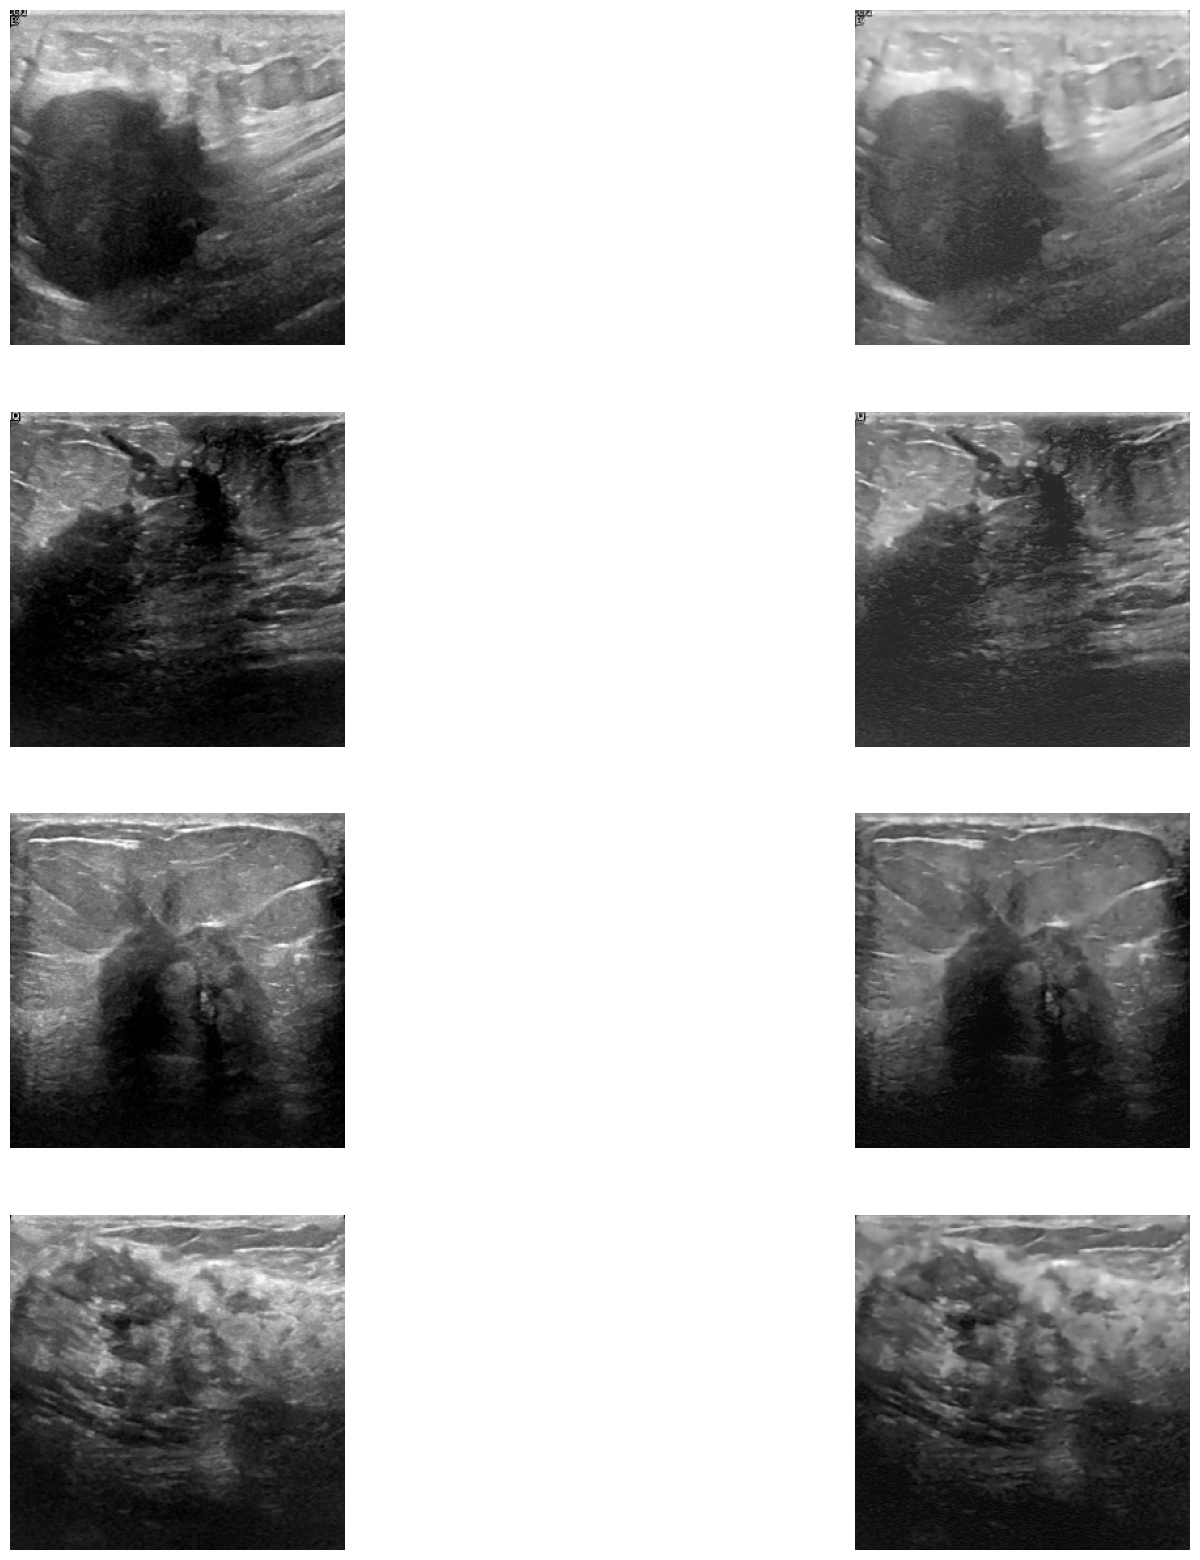

In [22]:
if __name__ == '__main__':
      N_show = 4

plt.figure(figsize=(10*2, 5*N_show))
for i in range(N_show):
  plt.subplot(N_show, 2, 2*i+1)
  plt.imshow(test_ims[i], cmap='gray')
  plt.axis('off')

  plt.subplot(N_show, 2, 2*i+2)
  plt.imshow(b[i].squeeze().cpu().detach().numpy(), cmap='gray')
  plt.axis('off')
plt.show()